In [2]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')
#데이터를 요약해서 보기 위한 판다스 메소드
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


특성의 스케일이 다르다는 것을 파악해야 전처리가 가능하다. 위의 메소드를 통해 그 사실을 파악 할 수 있다.

In [3]:
#판다스 데이터 프레임을 넘파이 배열로 바꾼다
#훈련에 쓰일 데이터와 타겟으로 나눠주고
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()
#트레이닝셋과 테스트 셋을 분할하여 준비한다.
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [ ]:
#특성 표준화 전처리
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [ ]:
#로지스틱 회귀 모델을 사용 했을 때 예측 결과
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
#표준화된 트레이닝셋으로 훈련
lr.fit(train_scaled, train_target)

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


로지스틱 회귀 모델이 학습한 결과보다 설명이 쉬운 모델이 필요하다.
#결정트리

In [ ]:
#결정 트리 모델로 학습
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.996921300750433
0.8592307692307692


위의 결과를 보면 *오버피팅* 되었다는 것을 알 수 있다.

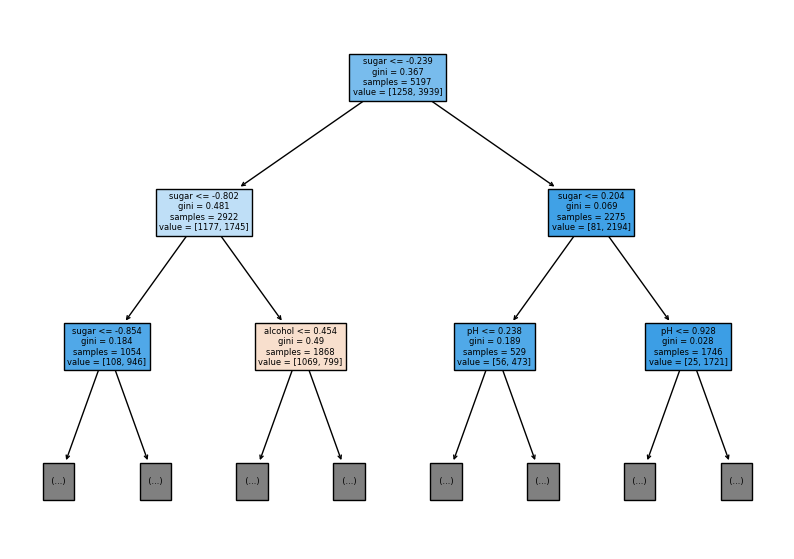

In [ ]:
#결정트리의 모양을 출력
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
#루트 노드를 제외한 n개의 노드 출련, 노드마다 컬러 다르게, 특성의 이름 표시
plot_tree(dt, max_depth=2, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

위 그래프에 대한 분석 및 불순도, 정보 이득은 블로그에 정리하도록 한다.
위에서 발견한 *오버피팅* 문제를 해결한다.
결정트리의 하이퍼 파라미터인 트리 깊이를 조정해야겠지.

In [ ]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)

print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


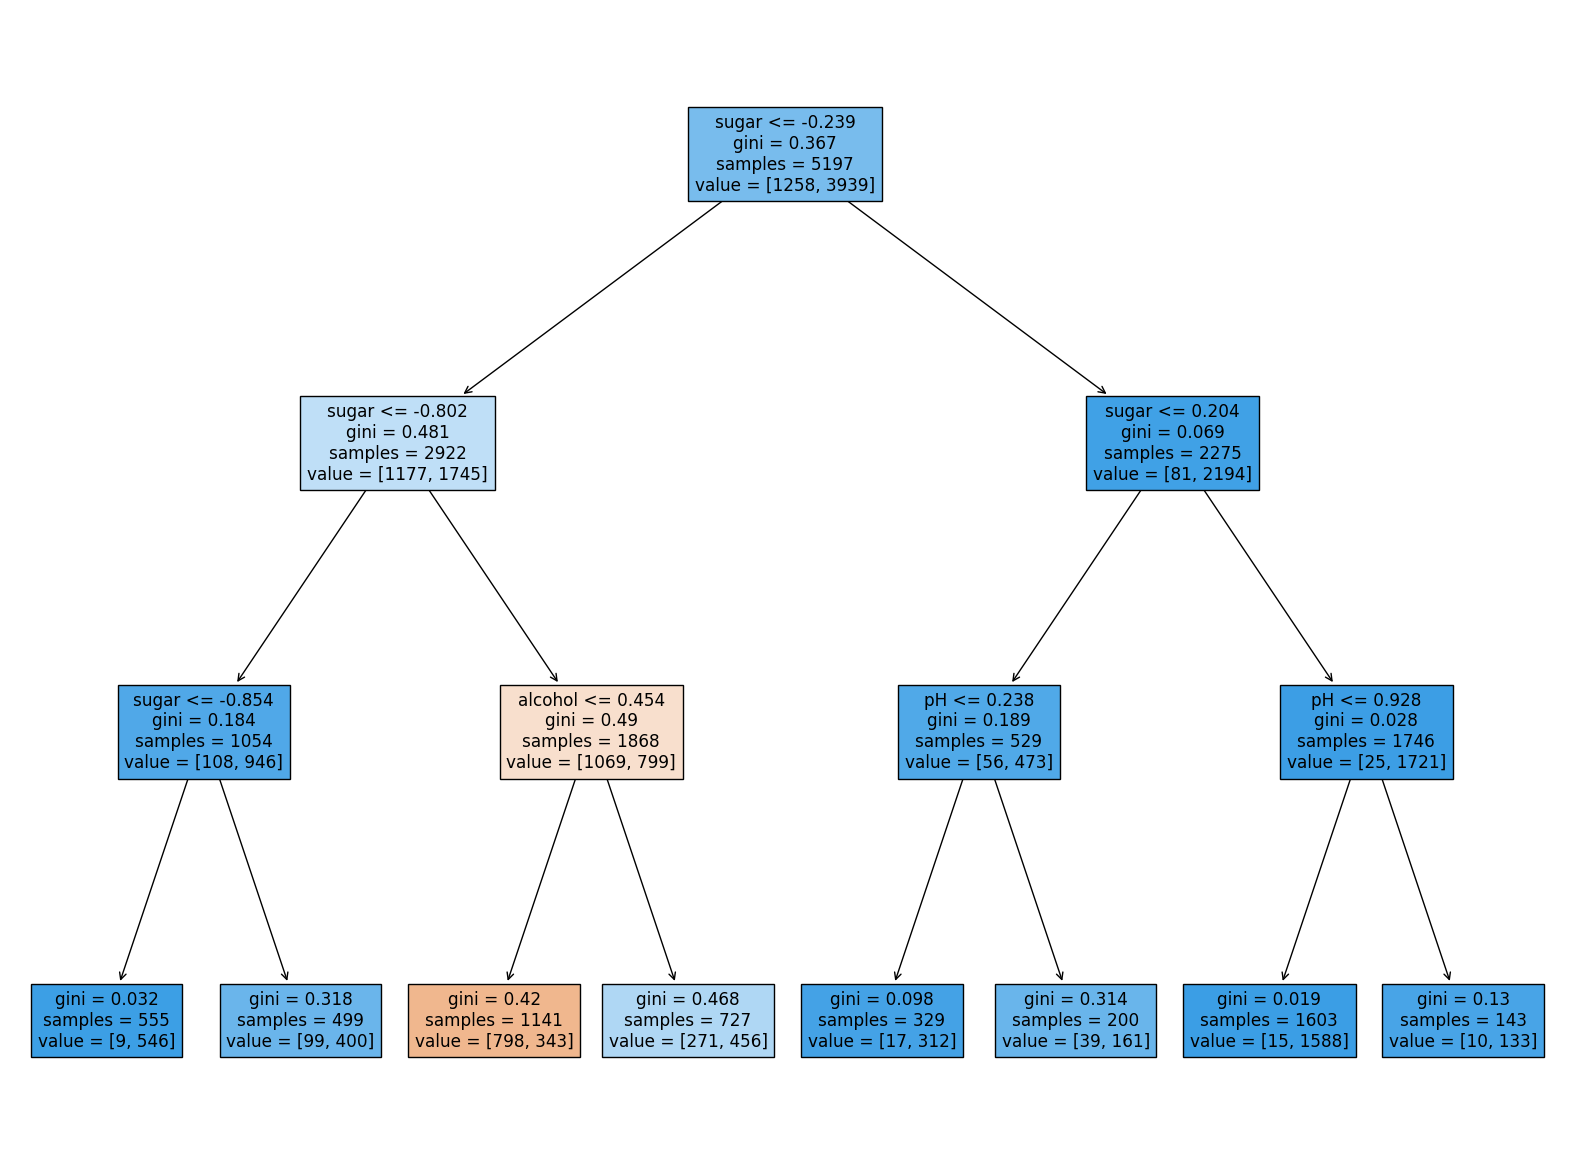

In [ ]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

위의 그래프에서 -0.802<와인의 당도<=-0.239
여야 레드 와인(음성)으로 분류 됨을 알 수 있다. 당도가 음수가 나왔다는 것이 이상하다. 앞서 전처리 과정 때문이고, 오히려 해석이 어려워졌다.
*결정트리 모델은 표준화 전처리 과정이 필요 없다. 특성별로 개별적 처리가 되기 때문.*

0.8454877814123533
0.8415384615384616


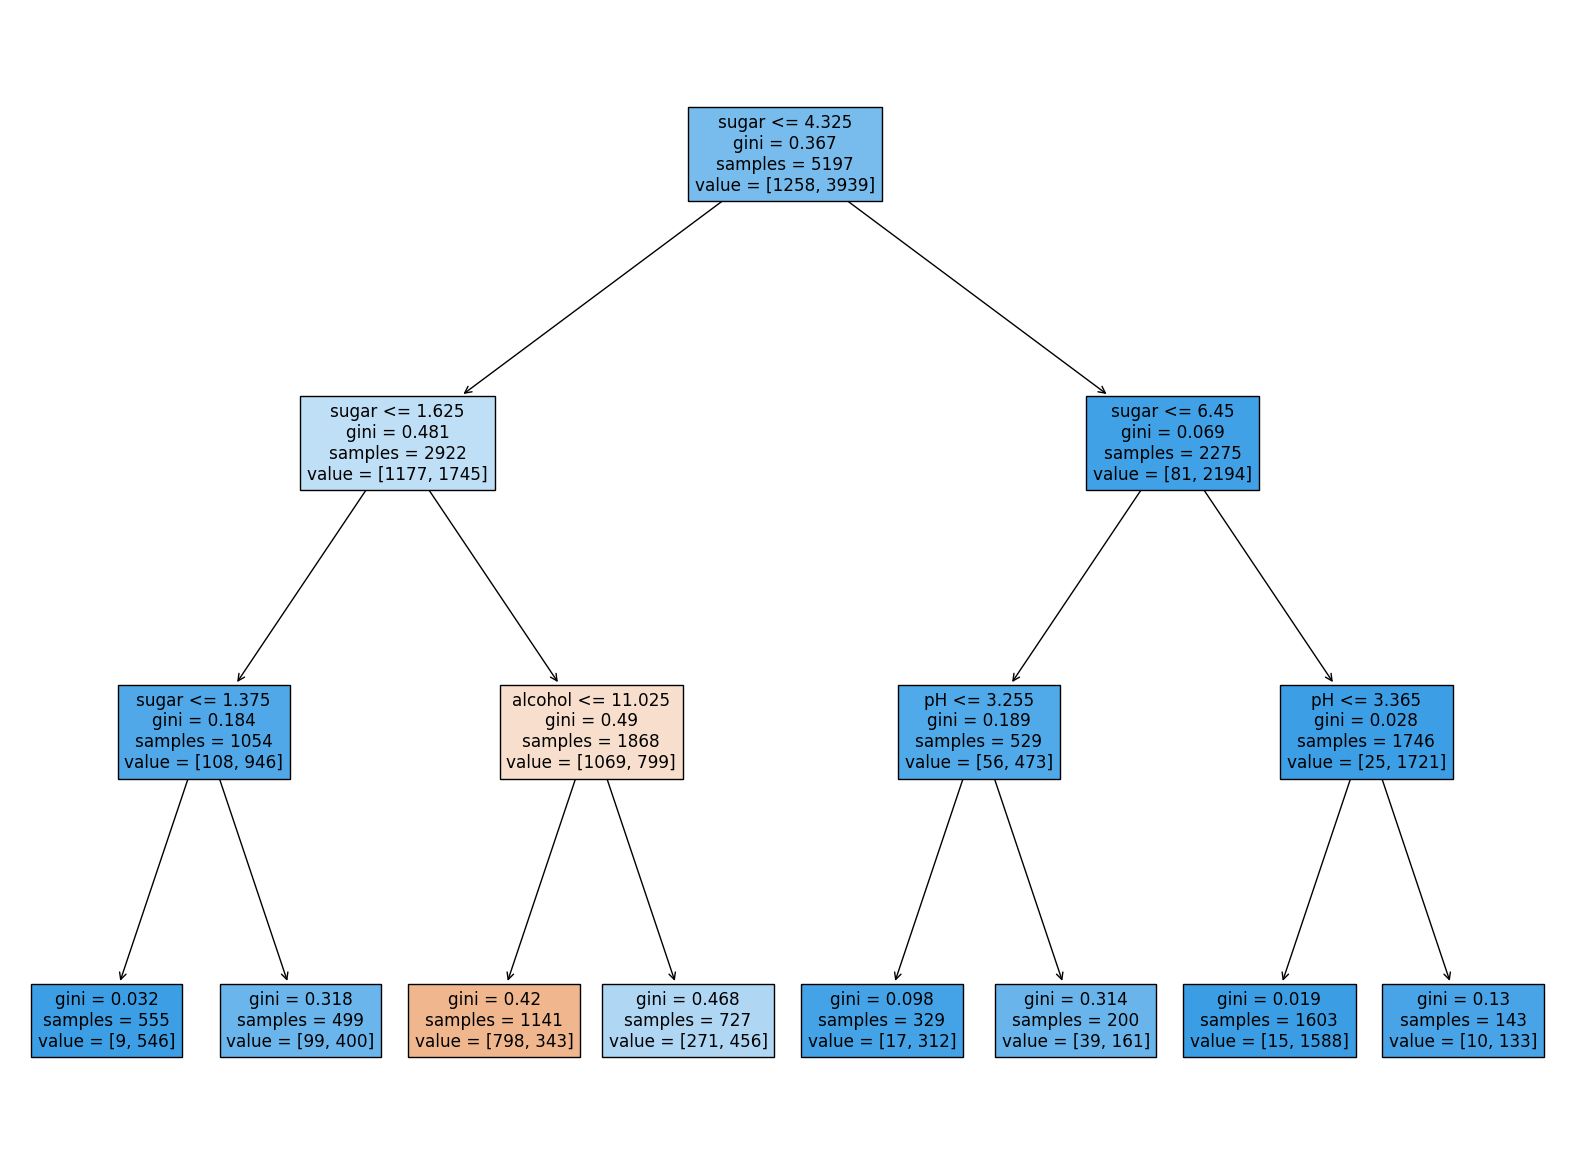

In [ ]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

표준화 전처리를 하지 않은 데이터셋으로 훈련한 모델의 성능과 차이가 없음을 확인. 당도도 양수 값으로 나타내어 직관적으로 판단하기 용이.
**특성 중요도**
데이터에 attribute가 많다면 어떤 특성을 모델에 반영 해야 할지 판단해야함. 특성 중요도를 분석해야겠지.

In [ ]:
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


특성 순서대로 2번째 특성인 당도가 가장 높은 중요도를 가진다는 것을 알 수 있다.

테스트세트를 여러번 사용하여 하이퍼 파라미터를 결정하는 것은 일반화 성능을 검증하는데 옳지 않다. 따라서 드레이닝 셋의 일부를
# 검증세트로 활용하여 하이퍼 파라미터를 결정하는데 활용한다.

In [5]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)
#train_test_split() 2번 사용_트레이닝셋을 훈련, 검증 셋으로 나눔
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)
#나눠진 결과 확인_일정 비율로 나뉘었음을 확인
print(sub_input.shape, val_input.shape)
#위에서 나눈 트레이닝셋으로 모델 학습
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
#분할 한 트레이닝셋으로 모델 학습
dt.fit(sub_input, sub_target)
#위에서 나눈 트레이닝셋과 검증셋의 예측 결과 확인
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

(4157, 3) (1040, 3)
0.9971133028626413
0.864423076923077


위의 결과에서 문제점을 짚어보자. 1. 훈련데이터에 오버피팅 2. 훈련세트가 줄어들어 모델의 성능이 떨어질 것으로 예상
#2번 문제를 해결하기 위한 교차검증에 대해 알아보자


In [7]:
from sklearn.model_selection import cross_validate
#메소드에 평가할 객체를 넘겨주고, 분할 하지 않은 원본 트레이닝셋을 넘겨준다.
scores = cross_validate(dt, train_input, train_target)
print(scores)
#교차검증으로 얻은 검증 폴드 점수 구하기_평균 계산
import numpy as np

print(np.mean(scores['test_score']))

{'fit_time': array([0.00736237, 0.01053357, 0.00613332, 0.00610352, 0.00607252]), 'score_time': array([0.00094914, 0.00076365, 0.00070977, 0.00082731, 0.00077915]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}
0.855300214703487


모델별로 n개의 하이퍼 파라미터가 존재한다. n개의 매개변수들은 서로에게 독립적이지 않으므로 동시에 튜닝해야한다. 교차검증에서 최적의 하이퍼 파라미터를 찾기 위해
#그리드서치를 활용하여 하이퍼 파라미터를 튜닝한다.


In [8]:
from sklearn.model_selection import GridSearchCV
#무슨 파라미터를 어떤 값으로 탐색 할 지 지정한다.
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
#어떤 머데르이 파라미터를 탐색 할지 지정하여 그리드서치 객체를 생성
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
#모델 만들기
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [11]:
#gs속성>>best_estimator_ 을 통해 최적의 파라미터로 훈련한 모델 찾아
dt = gs.best_estimator_
#전체 트레이닝 셋에 대해 다시 훈련_하이퍼 파라미터를 전체 훈련셋에 적용하는게 목적이니까
print(dt.score(train_input, train_target))
#위에서 찾은 모델의 최적의 파라미터 출력
print(gs.best_params_)
#파라미터에 따라 훈련한 모델들의 교차 검증 평균값을 비교해서 위의 결과와 일치하는지 확인
print(gs.cv_results_['mean_test_score'])

#위의 코드를 한번에 작성하면
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

0.9615162593804117
{'min_impurity_decrease': 0.0001}
[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]
{'min_impurity_decrease': 0.0001}


In [12]:
#여러개의 파라미터를 한번에 튜닝하자.
params = {#0.0001-0.001까지 0.0001씩 늘려 검증
    'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          #5-20 1씩 늘려 검증
          'max_depth': range(5, 20, 1),
          #2-100 10씩 늘려 검증
          'min_samples_split': range(2, 100, 10)
          }
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [13]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}
0.8683865773302731


셀 8보다 셀12 수행 시간이 훨씬 오래걸렸다. 또한, 파라미터릐 값의 범위, 간격을 위처럼 지정한 근거가 없다. 그리드서치만을 활용하는 것보다
#교차 검증 수를 줄이면서 최적의 파라미터 조합을 찾기 위한 랜덤서치를 활용한다.

In [14]:
#싸이파이 라이브러리 사용_uniform, randint 클래스 임포트
from scipy.stats import uniform, randint
#uniform 클래스로 실숫값 뽑는 객체 생성
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          #randint 클래스로 정숫값 뽑는 객체 생성
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }
          #위에서 만든 객체에서 n개의 숫자를 샘플링 할거다.
          #사이킷런 라이브러리>>RandomizedSearchCV 임포트
from sklearn.model_selection import RandomizedSearchCV
#n_iter 속성으로 샘플링 갯수 지정
#어떤 모델의,무슨 종류의 파라미터를,몇개의 샘플링으로 최적 파라미터 조합을 구할 것인지.
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)
#최적 파라미터 조합 결과 조회
print(gs.best_params_)
#최적 모델의 전체 트레이닝 셋 훈련 결과
print(np.max(gs.cv_results_['mean_test_score']))

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}
0.8695428296438884


In [15]:
#gs속성>>best_estimator_ 을 통해 최적의 파라미터로 훈련한 모델 찾아
dt = gs.best_estimator_
#테스트셋에 대한 결과
print(dt.score(test_input, test_target))

0.86
